In [3]:
# Install dependencies
# !pip install -r requirements.txt

Exporting to ONNX is a 2 step proces. Since FastAI is a high-level API built on top of PyTorch - we first need to export the model to .pth. And only after that it's possible to export to ONNX. A couple of things must be considered which I'll talk about later.

Steps:
1. Extract PyTorch model from FastAI
2. Convert PyTorch model to ONNX

## TODO Format

## 0. (Optional) Train your own resnet model

### Dataset



1. Dataset used in this notebook: https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog/data.

2. Training your own models - If you'd like to train a model with your own data please keep the folder structure - each folder and image in the folder should have the label in their name. The label is extracted with regex `r'(.+)_\d+.jpg$'`. If you have a dataset with a different naming convention please define a suitable regex. For other options see https://docs.fast.ai/tutorial.vision.html

Folder structure:

        dataset
        ├───hot_dog
        │   ├───hot_dot_1.png
        │   ├───hot_dot_2.png
        │   └───hot_dot_xyz.png
        └───not_hot_dog
            ├───not_hot_dot_1.png
            ├───not_hot_dot_2.png
            └───not_hot_dot_xyz.png


In [12]:
# imports
from fastai.vision.all import *

In [2]:
# set dataset root directory
PATH = Path('dataset/')

In [4]:
# By itself, a DataBlock is just a blue print on how to assemble your data
# https://docs.fast.ai/data.block.html
# Good write up here: https://www.kaggle.com/getting-started/168549

dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(),          # splits dataset to train and test
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    item_tfms=Resize(256),              # applied to all items in a dataset
    batch_tfms=aug_transforms(size=256) # batch transformations
    )

In [8]:
dls = dogs.dataloaders(PATH, num_workers=0, verbose=True) # CPU implmentation

Found 200 items
2 datasets of sizes 160,40
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: Resize -- {'size': (256, 256), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': 256, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}


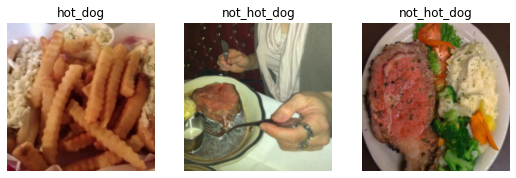

In [9]:
# show a random batch of images with their labels
dls.show_batch(max_n=3)

In [10]:
# Creates CNN learner
# you can find other supported models here:
# please stick to resnet models - resnet18, resnet34, resnet50, resnet101, resnet152
# in general more layers -> longer training and better performance

learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy])

In [ ]:
# finds the best learning rate
# Check this article for the maths behind: 
# https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

learn.lr_find()

In [11]:
# you might want to change the number of training epochs - 1. argument
# you should adjust the learning rate based on the previous step - 2. argument

learn.fine_tune(8, 1e-3)

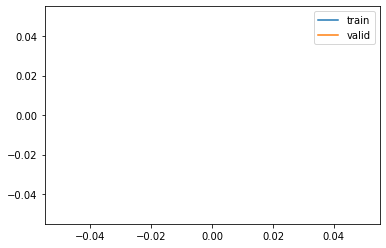

In [30]:
# Plotting loss 
learn.recorder.plot_loss()

In [21]:
# export FastAI model

learn.export('models/hot_dog_model_resnet18_256_256.pkl')

In [13]:
# loading FastAI model

learn = load_learner('models/hot_dog_model_resnet18_256_256.pkl')

In [28]:
learn.predict('test_images/not_hot_dog_160.jpg')

('not_hot_dog', tensor(1), tensor([0.0018, 0.9982]))

In [29]:
learn.predict('test_images/hot_dog_114.jpg')

('hot_dog', tensor(0), tensor([9.9910e-01, 8.9894e-04]))

## 1. Getting PyTorch model

By using .model attribute on the FastAI learner we can get the 'pure' PyTorch model. By using eval() we are setting the model to 'prediction' mode - no backward propagation needed.

FastAI learner wraps the PyTorch model with additional operations defined in `DataBlock` in this case we defined a `Resize` operation. There's also a softmax layer as the last layer and a normalization layer.

### What does this mean ?
If we run `learn.predict('path/to/image')` the FastAI learner resizes the image to the defined size, normalizes the color channels, passes the image through the neural net, and the softmax layer scales the inference results between 0-1.

If we'd try to run inference on the PyTorch model extracted from the FastAI wrapper it would fail (most likely) as the image has wrong resulution. That's why we need to add transformations to PyTorch models before inference.

In [14]:
# transformations performed in data loaders
learn.dls.transform

(#2) [[noop:
encodes: (object,object) -> noopdecodes: , PILBase.create:
encodes: (Path,object) -> create
(str,object) -> create
(Tensor,object) -> create
(ndarray,object) -> create
(bytes,object) -> createdecodes: ],partial:
encodes: (object,object) -> partialdecodes: ]

In [15]:
# extract labels from learner
labels = learn.dls.vocab
labels

['hot_dog', 'not_hot_dog']

### Let's add the missing parts to our Pytorch model

In [96]:
import torch
import torchvision
import torchvision.transforms as transforms

# https://pytorch.org/vision/stable/models.html

pytorch_model = learn.model.eval() # gets the PyTorch model
softmax_layer = torch.nn.Softmax(dim=1) # define softmax
normalization_layer = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization layer


final_model = nn.Sequential(
    normalization_layer,
    pytorch_model,
    softmax_layer
)

# Note: Image resize will be handled separately


In [97]:
# loading an image and converting to tensor
from PIL import Image

def image_transform(path: str) -> torch.Tensor:
    '''Helper function to transform image.'''
    image = Image.open(path)

    # transformation pipeline
    transformation = transforms.Compose([
                transforms.Resize([256,256]), # resizes image
                transforms.ToTensor() # converts to image to tensor
            ])

    image_tensor = transformation(image).unsqueeze(0)
    print('Tensor shape: ',image_tensor.shape)

    return image_tensor

In [98]:
hot_dog_test = 'test_images/hot_dog_114.jpg'
not_hot_dog_test = 'test_images/not_hot_dog_160.jpg'

In [99]:
hot_dog_tensor = image_transform(hot_dog_test)
not_hot_dog_tensor = image_transform(not_hot_dog_test)

Tensor shape:  torch.Size([1, 3, 256, 256])
Tensor shape:  torch.Size([1, 3, 256, 256])


In [100]:
with torch.no_grad():
    results = final_model(hot_dog_tensor)
labels[np.argmax(results.detach().numpy())], results.detach().numpy()

('hot_dog', array([[9.9910104e-01, 8.9900475e-04]], dtype=float32))

In [95]:
with torch.no_grad():
    results = final_model(not_hot_dog_tensor)
labels[np.argmax(results.detach().numpy())], results.detach().numpy()

('not_hot_dog', array([[0.01378838, 0.98621166]], dtype=float32))

## 2. Export PyTorch model to ONNX

It's REALLY important to define the input shape of the ONNX model. We trained the FastAI/PyTorch model with 256 x 256 dimensions. Therefore we need to use the same for export. The input tensor must be BCHW - 1x3x256x256.

In [102]:
torch.onnx.export(
    final_model, 
    torch.randn(1, 3, 256, 256),
    "models/hot_dog_model_resnet18_256_256.onnx",
    export_params=True,
    input_names=["image_1_3_256_256"],
    output_names=["hot_dog"],
    opset_version=11
)

We got out ONNX model. Let's check if we get the same results.

In [1]:
import numpy as np
import onnxruntime as rt

In [19]:
from PIL import Image

def image_transform_onnx(path: str, size: int) -> np.ndarray:
    '''Image transform helper for onnx runtime inference.'''

    image = Image.open(path)
    image = image.resize((size,size))
    # print(image.shape, image.mode)


    # now our image is represented by 3 layers - Red, Green, Blue
    # each layer has a 224 x 224 values representing
    image = np.array(image)
    print('Conversion to tensor: ',image.shape)

    # dummy input for the model at export - torch.randn(1, 3, 224, 224)
    image = image.transpose(2,0,1).astype(np.float32)
    print('Transposing the tensor: ',image.shape)

    # our image is currently represented by values ranging between 0-255
    # we need to convert these values to 0.0-1.0 - those are the values that are expected by our model

    print('Integer value: ', image[0][0][40])
    image /= 255
    print('Float value: ', image[0][0][40])

    # expanding the alread existing tensor with the final dimension (similar to unsqueeze(0))
    # currently our tensor only has rank of 3 which needs to be expanded to 4 - torch.randn(1, 3, 224, 224)
    # 1 can be considered the batch size

    image = image[None, ...]
    print('Final shape of our tensor', image.shape)
    return image


In [20]:
hot_dog_tensor_onnx = image_transform_onnx('test_images/hot_dog_114.jpg', 256)
not_hot_dog_tensor_onnx = image_transform_onnx('test_images/not_hot_dog_160.jpg', 256)


Conversion to tensor:  (256, 256, 3)
Transposing the tensor:  (3, 256, 256)
Integer value:  44.0
Float value:  0.17254902
Final shape of our tensor (1, 3, 256, 256)
Conversion to tensor:  (256, 256, 3)
Transposing the tensor:  (3, 256, 256)
Integer value:  81.0
Float value:  0.31764707
Final shape of our tensor (1, 3, 256, 256)


In [21]:
# initialize onnx runtime inference session
sess = rt.InferenceSession('models/hot_dog_model_resnet18_256_256.onnx')

input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

input_dims = sess.get_inputs()[0].shape

input_name, output_name, input_dims

('image_1_3_256_256', 'hot_dog', [1, 3, 256, 256])

In [22]:
results = sess.run([output_name], {input_name: hot_dog_tensor_onnx})[0]
labels[np.argmax(results)], results, labels

('hot_dog',
 array([[0.9986059 , 0.00139411]], dtype=float32),
 ['hot_dog', 'not_hot_dog'])

In [23]:
results = sess.run([output_name], {input_name: not_hot_dog_tensor_onnx})[0]
labels[np.argmax(results)], results, labels

('not_hot_dog',
 array([[0.01864218, 0.98135775]], dtype=float32),
 ['hot_dog', 'not_hot_dog'])

## Gotchas

It's really important to use the expected input with ONNX. Let's check the following scenario when using a 1x3x224x224 tensor with on a model with a defined input of 1x3x256x256.

Let's see what happens

In [25]:
hot_dog_tensor_onnx = image_transform_onnx('test_images/hot_dog_114.jpg', 224)
not_hot_dog_tensor_onnx = image_transform_onnx('test_images/not_hot_dog_160.jpg', 224)

Conversion to tensor:  (224, 224, 3)
Transposing the tensor:  (3, 224, 224)
Integer value:  28.0
Float value:  0.10980392
Final shape of our tensor (1, 3, 224, 224)
Conversion to tensor:  (224, 224, 3)
Transposing the tensor:  (3, 224, 224)
Integer value:  84.0
Float value:  0.32941177
Final shape of our tensor (1, 3, 224, 224)


In [26]:
results = sess.run([output_name], {input_name: hot_dog_tensor_onnx})[0]
labels[np.argmax(results)], results, labels

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: image_1_3_256_256 for the following indices
 index: 2 Got: 224 Expected: 256
 index: 3 Got: 224 Expected: 256
 Please fix either the inputs or the model.

## How to Debug

To check the inputs of a model you can use a tool like Netron to visualize it: https://netron.app. Desktop version available here: https://github.com/lutzroeder/netron

OR you can access the expected dimension by the following line:


In [28]:
# shows the required model input
sess.get_inputs()[0].shape

[1, 3, 256, 256]


1. Trained Resnet50 models here (if you do not wish to train your own model): 
        
        https://storage.googleapis.com/dsu-models-20020301/example-2-pytorch/hot_dog_resnet50_256_256.onnx
        https://storage.googleapis.com/dsu-models-20020301/example-2-pytorch/hot_dog_resnet50_256_256.pkl
